### Visualizing the distribution of the observations

### Load the required libraries

In [30]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[4]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/Users/himanshujaiswal/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[4]) created by __init__ at <ipython-input-3-c66082553228>:13 

### Select data for a particular station and measurement type

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00266782')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00266782'
19 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1369.5| 39.5333|-119.8167|       PRCP|USC00266782|     3|[80 4A 20 50 00 0...|1894.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       PRCP|USC00266782|    33|[00 00 00 00 00 0...|1895.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(19, 365)

### Script for plotting yearly plots

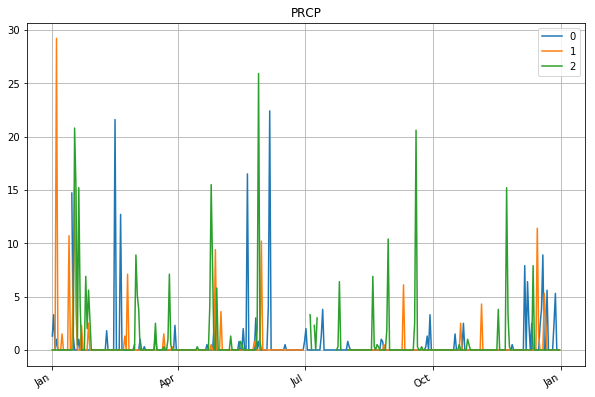

In [10]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:3,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [11]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

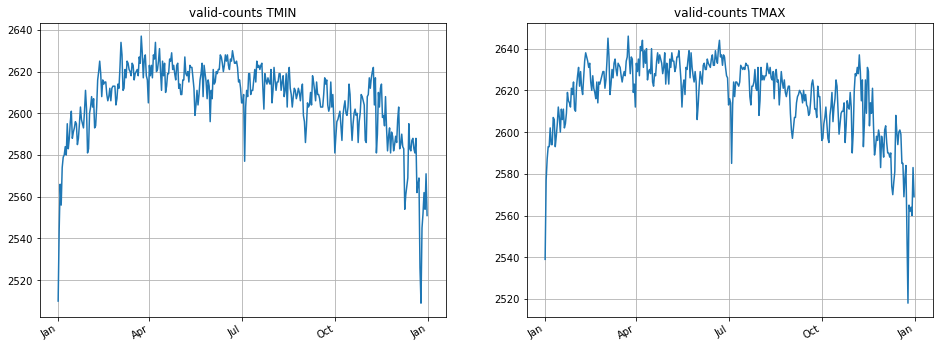

In [12]:
plot_pair(['TMIN','TMAX'],plot_valid)

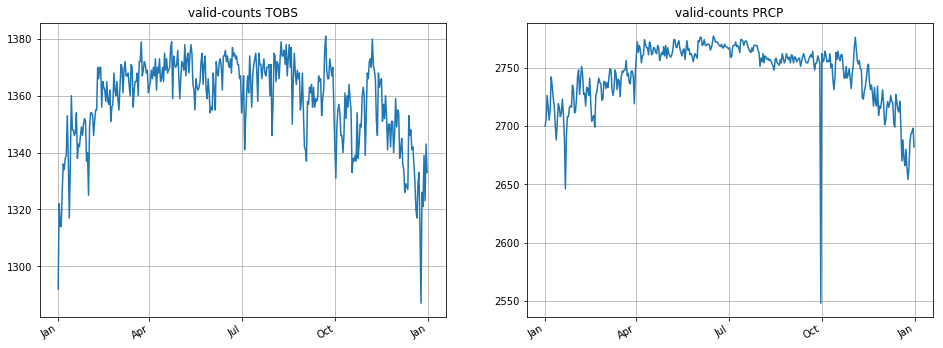

In [13]:
plot_pair(['TOBS','PRCP'],plot_valid)

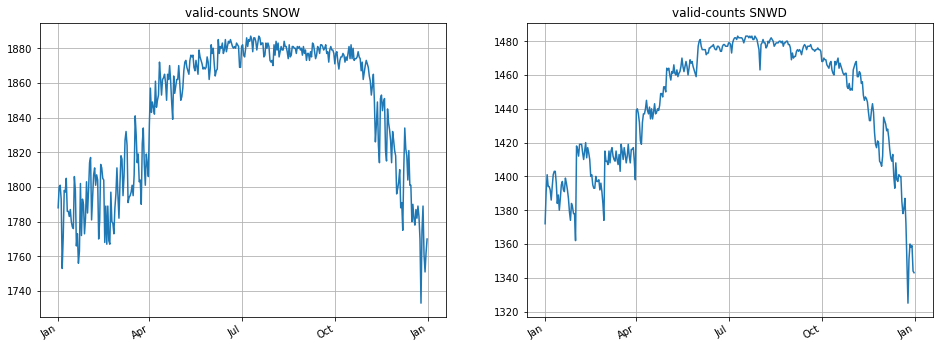

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [17]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

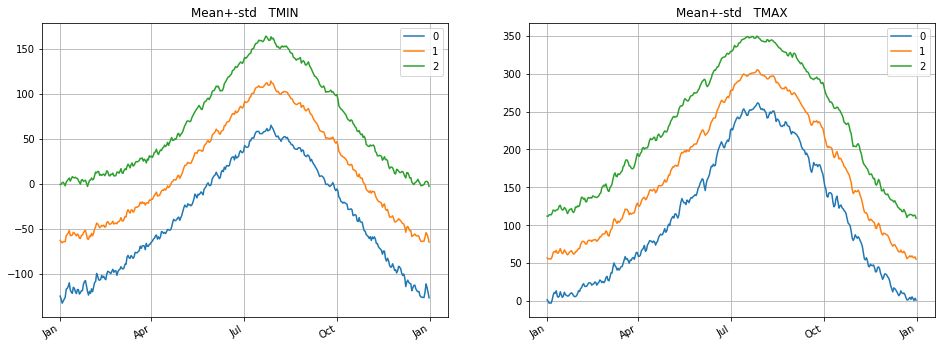

In [18]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

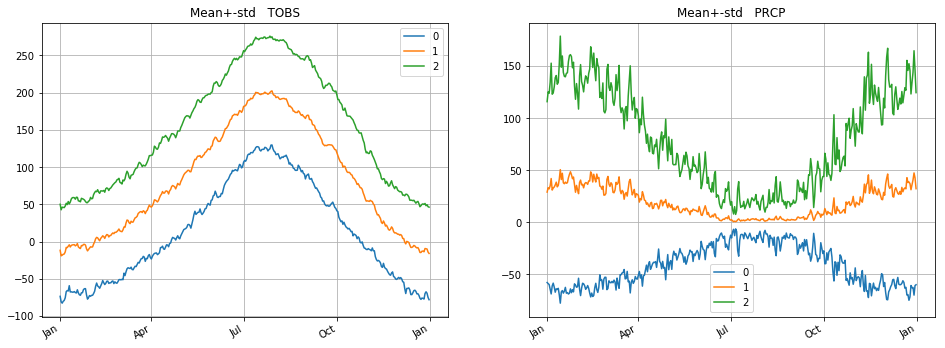

In [19]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

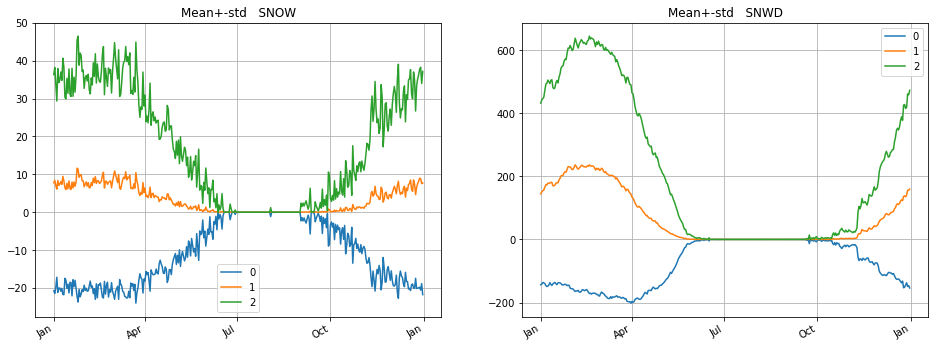

In [20]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [21]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

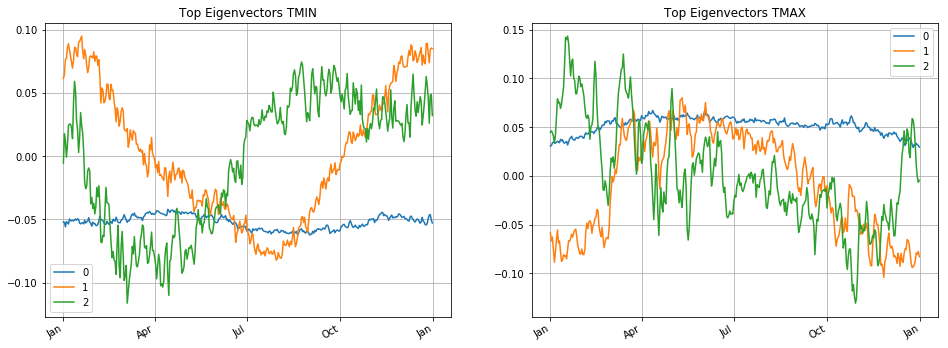

In [22]:
plot_pair(['TMIN','TMAX'],plot_eigen)

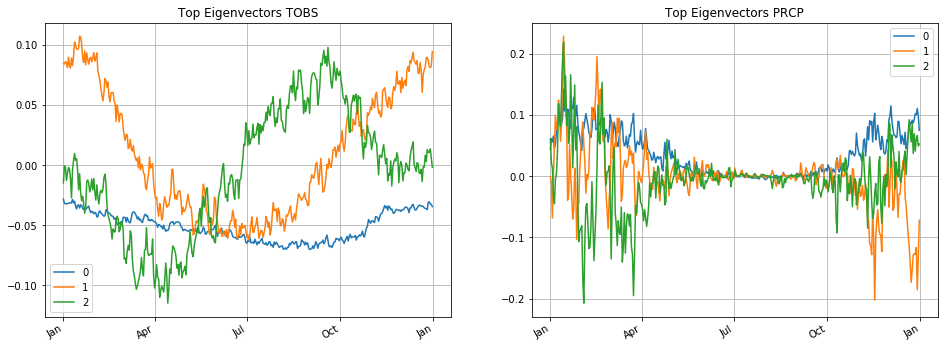

In [23]:
plot_pair(['TOBS','PRCP'],plot_eigen)

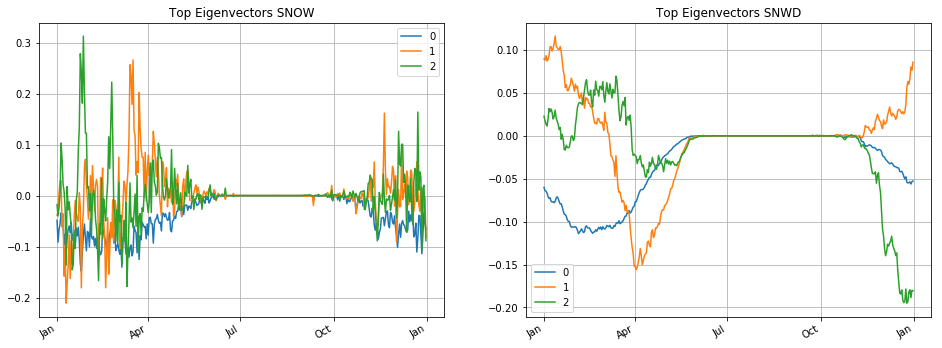

In [24]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [25]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

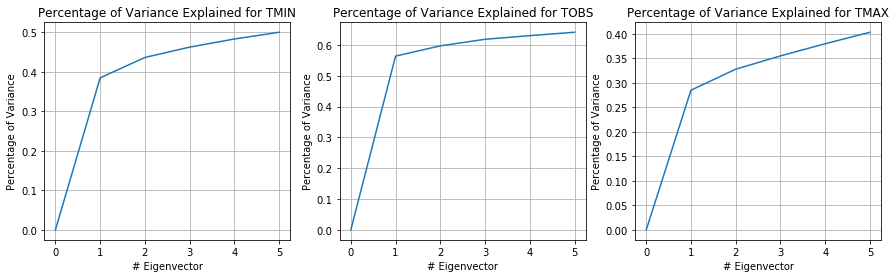

In [26]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

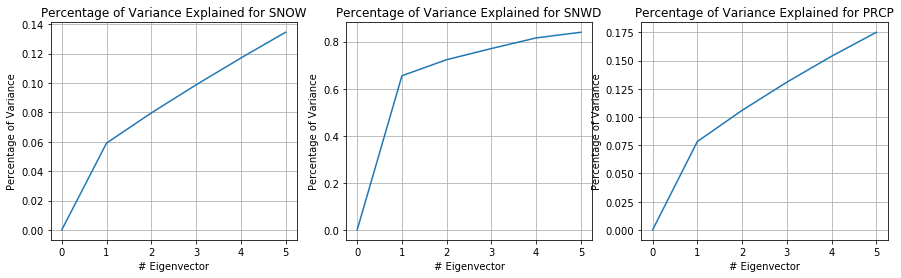

In [27]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [28]:
#sc.stop()

In [29]:
STAT['TMIN'].keys()

['std',
 'UnDef',
 'E',
 'Cov',
 'high1000',
 'NE',
 'O',
 'low100',
 'NO',
 'high100',
 'eigvec',
 'low1000',
 'Var',
 'eigval',
 'mean',
 'SortedVals',
 'Mean']

In [41]:
STAT['TMIN']['eigval']

array([  3.83228258e+05,   5.13532749e+04,   2.60585202e+04,
         2.04346286e+04,   1.70402076e+04,   1.49159215e+04,
         1.40191523e+04,   1.30532929e+04,   1.25433724e+04,
         1.15834384e+04,   1.07647525e+04,   1.03793185e+04,
         1.01268883e+04,   9.78928060e+03,   9.18697612e+03,
         8.74002341e+03,   8.39076911e+03,   8.20351361e+03,
         8.07412417e+03,   7.31014041e+03,   7.18681793e+03,
         6.94423662e+03,   6.82664878e+03,   6.40542308e+03,
         6.07909695e+03,   5.95136627e+03,   5.81865984e+03,
         5.71302544e+03,   5.42561231e+03,   5.35296333e+03,
         5.27085468e+03,   5.05841060e+03,   4.76632790e+03,
         4.68455815e+03,   4.56734702e+03,   4.49745899e+03,
         4.40049502e+03,   4.25804121e+03,   4.18511575e+03,
         4.05327382e+03,   3.93887104e+03,   3.85369247e+03,
         3.73043400e+03,   3.61718115e+03,   3.50092428e+03,
         3.36073468e+03,   3.40501164e+03,   3.19867440e+03,
         3.15298860e+03,